Called with args:
<__main__._args instance at 0x7f656d21dab8>
Using config:
{'DATA_DIR': '/home/yxchen/py-faster-rcnn/data',
 'DEDUP_BOXES': 0.0625,
 'EPS': 1e-14,
 'EXP_DIR': 'default',
 'GPU_ID': 1,
 'MATLAB': 'matlab',
 'MODELS_DIR': '/home/yxchen/py-faster-rcnn/models/caltech',
 'PIXEL_MEANS': array([[[ 123.68 ,  116.779,  103.939]]]),
 'RNG_SEED': 3,
 'ROOT_DIR': '/home/yxchen/py-faster-rcnn',
 'TEST': {'BBOX_REG': True,
          'HAS_RPN': False,
          'MAX_SIZE': 1000,
          'NMS': 0.3,
          'PROPOSAL_METHOD': 'selective_search',
          'RPN_MIN_SIZE': 16,
          'RPN_NMS_THRESH': 0.5,
          'RPN_POST_NMS_TOP_N': 2000,
          'RPN_PRE_NMS_TOP_N': -1,
          'SCALES': [600],
          'SVM': False},
 'TRAIN': {'ASPECT_GROUPING': True,
           'BATCH_SIZE': 120,
           'BBOX_INSIDE_WEIGHTS': [1.0, 1.0, 1.0, 1.0],
           'BBOX_NORMALIZE_MEANS': [0.0, 0.0, 0.0, 0.0],
           'BBOX_NORMALIZE_STDS': [0.1, 0.1, 0.2, 0.2],
           'BBOX_NOR

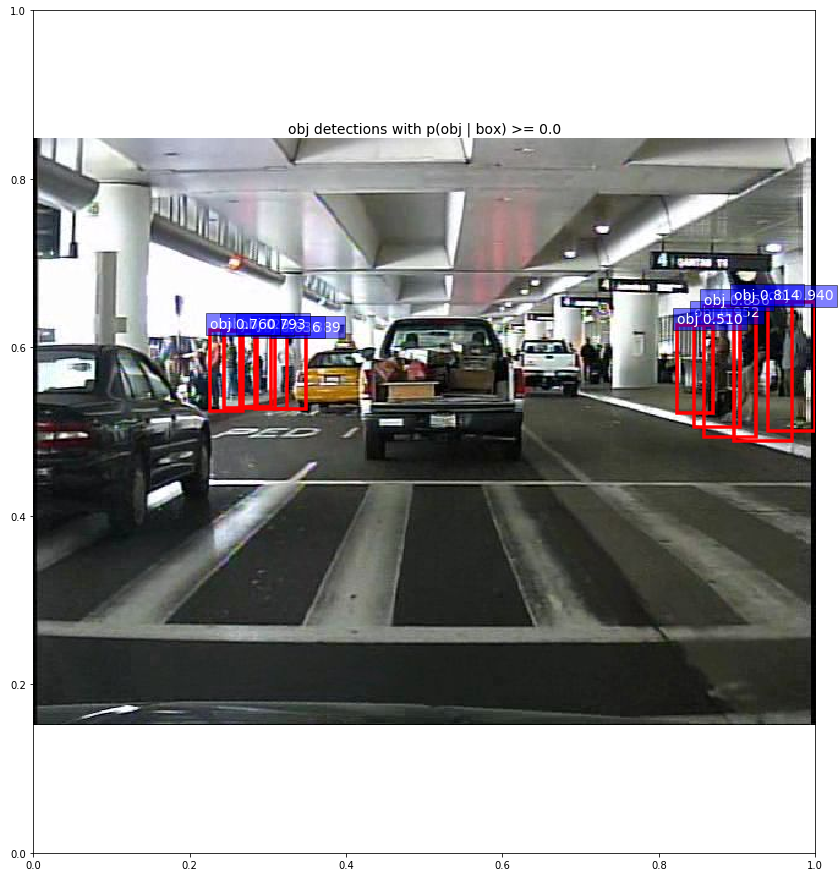

Wrote RPN proposals to /home/yxchen/py-faster-rcnn/output/default/caltech_train/vgg16_rpn_stage1_iter_16000/vgg16_rpn_stage1_iter_16000_rpn_proposals.pkl


In [1]:
# --------------------------------------------------------
# Faster R-CNN
# Copyright (c) 2015 Microsoft
# Licensed under The MIT License [see LICENSE for details]
# Written by Ross Girshick
# --------------------------------------------------------

%matplotlib inline
import matplotlib.pyplot as plt

import _init_paths
from fast_rcnn.config import cfg
from utils.blob import im_list_to_blob
from utils.timer import Timer
import numpy as np
import cv2

def _vis_proposals(im, dets, thresh=0.5):
    """Draw detected bounding boxes."""
    
    inds = np.where(dets[:, -1] >= thresh)[0]
    if len(inds) == 0:
        return

    class_name = 'obj'
    im = im[:, :, (2, 1, 0)]
    fig, ax = plt.subplots(figsize=(12, 12))
    ax = fig.add_subplot(111)
    ax.imshow(im, aspect='equal')
    for i in inds:
        bbox = dets[i, :4]
        score = dets[i, -1]

        ax.add_patch(
            plt.Rectangle((bbox[0], bbox[1]),
                          bbox[2] - bbox[0],
                          bbox[3] - bbox[1], fill=False,
                          edgecolor='red', linewidth=3.5)
            )
        ax.text(bbox[0], bbox[1] - 2,
                '{:s} {:.3f}'.format(class_name, score),
                bbox=dict(facecolor='blue', alpha=0.5),
                fontsize=14, color='white')

    ax.set_title(('{} detections with '
                  'p({} | box) >= {:.1f}').format(class_name, class_name,
                                                  thresh),
                  fontsize=14)
    plt.axis('off')
    plt.tight_layout()
    plt.draw()

def _get_image_blob(im):
    """Converts an image into a network input.

    Arguments:
        im (ndarray): a color image in BGR order

    Returns:
        blob (ndarray): a data blob holding an image pyramid
        im_scale_factors (list): list of image scales (relative to im) used
            in the image pyramid
    """
    im_orig = im.astype(np.float32, copy=True)
    im_orig -= cfg.PIXEL_MEANS

    im_shape = im_orig.shape
    im_size_min = np.min(im_shape[0:2])
    im_size_max = np.max(im_shape[0:2])

    processed_ims = []

    assert len(cfg.TEST.SCALES) == 1
    target_size = cfg.TEST.SCALES[0]

    im_scale = float(target_size) / float(im_size_min)
    # Prevent the biggest axis from being more than MAX_SIZE
    if np.round(im_scale * im_size_max) > cfg.TEST.MAX_SIZE:
        im_scale = float(cfg.TEST.MAX_SIZE) / float(im_size_max)
    im = cv2.resize(im_orig, None, None, fx=im_scale, fy=im_scale,
                    interpolation=cv2.INTER_LINEAR)
    im_info = np.hstack((im.shape[:2], im_scale))[np.newaxis, :]
    processed_ims.append(im)

    # Create a blob to hold the input images
    blob = im_list_to_blob(processed_ims)

    return blob, im_info

def im_proposals(net, im):
    """Generate RPN proposals on a single image."""
    blobs = {}
    blobs['data'], blobs['im_info'] = _get_image_blob(im)
    net.blobs['data'].reshape(*(blobs['data'].shape))
    net.blobs['im_info'].reshape(*(blobs['im_info'].shape))
    blobs_out = net.forward(
            data=blobs['data'].astype(np.float32, copy=False),
            im_info=blobs['im_info'].astype(np.float32, copy=False))

    scale = blobs['im_info'][0, 2]
    boxes = blobs_out['rois'][:, 1:].copy() / scale
    scores = blobs_out['scores'].copy()
    return boxes, scores

def imdb_proposals(net, imdb):
    """Generate RPN proposals on all images in an imdb."""

    _t = Timer()
    imdb_boxes = [[] for _ in xrange(imdb.num_images)]
#    for i in xrange(imdb.num_images):
    for i in xrange(1):
        #im = cv2.imread(imdb.image_path_at(i))
        im = cv2.imread('/home/yxchen/RPN_BF/datasets/caltech/train/images/set00_V010_I00011.jpg')
        _t.tic()
        imdb_boxes[i], scores = im_proposals(net, im)
        _t.toc()
        print 'im_proposals: {:d}/{:d} {:.3f}s' \
              .format(i + 1, imdb.num_images, _t.average_time)
        if 1:
        #if 0:
            dets = np.hstack((imdb_boxes[i], scores))
            print dets
            # from IPython import embed; embed()
            global cache_image, cache_dets
            cache_image = im
            cache_dets = dets
            _vis_proposals(im, dets[0:10, :], thresh=0)

    return imdb_boxes

#!/usr/bin/env python

# --------------------------------------------------------
# Fast/er/ R-CNN
# Copyright (c) 2015 Microsoft
# Licensed under The MIT License [see LICENSE for details]
# Written by Ross Girshick
# --------------------------------------------------------

"""Generate RPN proposals."""

%matplotlib inline
import matplotlib.pyplot as plt

import _init_paths
import numpy as np
from fast_rcnn.config import cfg, cfg_from_file, cfg_from_list, get_output_dir
from datasets.factory import get_imdb
import cPickle
import caffe
import argparse
import pprint
import time, os, sys

def parse_args():
    """
    Parse input arguments
    """
    parser = argparse.ArgumentParser(description='Test a Fast R-CNN network')
    parser.add_argument('--gpu', dest='gpu_id', help='GPU id to use',
                        default=0, type=int)
    parser.add_argument('--def', dest='prototxt',
                        help='prototxt file defining the network',
                        default='/home/yxchen/py-faster-rcnn/models/caltech/VGG16/rpn_test.pt', type=str)
    parser.add_argument('--net', dest='caffemodel',
                        help='model to test',
                        default='/home/yxchen/py-faster-rcnn/output/default/caltech_train/vgg16_rpn_stage1_iter_16000.caffemodel', type=str)
    parser.add_argument('--cfg', dest='cfg_file',
                        help='optional config file', default=None, type=str)
    parser.add_argument('--wait', dest='wait',
                        help='wait until net file exists',
                        default=True, type=bool)
    parser.add_argument('--imdb', dest='imdb_name',
                        help='dataset to test',
                        default='caltech_train', type=str)
    parser.add_argument('--set', dest='set_cfgs',
                        help='set config keys', default=None,
                        nargs=argparse.REMAINDER)

    #if len(sys.argv) == 1:
    #    parser.print_help()
    #    sys.exit(1)

    args = parser.parse_args()
    print args
    return args

class _args():
    def __init__(self):
        self.gpu_id = 1
        self.prototxt = '/home/yxchen/py-faster-rcnn/models/caltech/VGG16/rpn_test.pt'
        self.caffemodel = '/home/yxchen/py-faster-rcnn/output/default/caltech_train/vgg16_rpn_stage1_iter_16000.caffemodel'
        self.imdb_name = 'caltech_train'
        self.cfg_file = None
        self.wait = True
        self.set_cfgs = None

if __name__ == '__main__':
    args = _args()
    
    cache_image = None
    cache_dets = None

    print('Called with args:')
    print(args)

    if args.cfg_file is not None:
        cfg_from_file(args.cfg_file)
    if args.set_cfgs is not None:
        cfg_from_list(args.set_cfgs)

    cfg.GPU_ID = args.gpu_id

    # RPN test settings
    cfg.TEST.RPN_PRE_NMS_TOP_N = -1
    cfg.TEST.RPN_POST_NMS_TOP_N = 2000

    print('Using config:')
    pprint.pprint(cfg)

    while not os.path.exists(args.caffemodel) and args.wait:
        print('Waiting for {} to exist...'.format(args.caffemodel))
        time.sleep(10)

    caffe.set_mode_gpu()
    caffe.set_device(args.gpu_id)
    net = caffe.Net(args.prototxt, args.caffemodel, caffe.TEST)
    net.name = os.path.splitext(os.path.basename(args.caffemodel))[0]

    imdb = get_imdb(args.imdb_name)
    imdb_boxes = imdb_proposals(net, imdb)
    plt.show()

    output_dir = get_output_dir(imdb, net)
    rpn_file = os.path.join(output_dir, net.name + '_rpn_proposals.pkl')
    with open(rpn_file, 'wb') as f:
        cPickle.dump(imdb_boxes, f, cPickle.HIGHEST_PROTOCOL)
    print 'Wrote RPN proposals to {}'.format(rpn_file)


In [ ]:
def a():
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot([1.5, 2, 3, 4], [10, 20, 25, 30], color='lightblue', linewidth=3)#绘制线
    ax.scatter([0.3, 3.8, 1.2, 2.5], [11, 25, 9, 26], color='darkgreen', marker='^')#绘制散点图
    ax.set_xlim(0.5, 4.5)

In [ ]:
im = cache_image
print len(cache_dets)
dets = cache_dets[0:10, :]
thresh = 0

inds = np.where(dets[:, -1] >= thresh)[0]
if len(inds) == 0:
    print 'error'

class_name = 'obj'
im = im[:, :, (2, 1, 0)]
fig, ax = plt.subplots(figsize=(12, 12))
ax = fig.add_subplot(111)
ax.imshow(im, aspect='equal')
for i in inds:
    bbox = dets[i, :4]
    score = dets[i, -1]

    ax.add_patch(
        plt.Rectangle((bbox[0], bbox[1]),
                      bbox[2] - bbox[0],
                      bbox[3] - bbox[1], fill=False,
                      edgecolor='red', linewidth=3.5)
        )
    ax.text(bbox[0], bbox[1] - 2,
            '{:s} {:.3f}'.format(class_name, score),
            bbox=dict(facecolor='blue', alpha=0.5),
            fontsize=14, color='white')

ax.set_title(('{} detections with '
              'p({} | box) >= {:.1f}').format(class_name, class_name,
                                              thresh),
              fontsize=14)
plt.axis('off')
plt.tight_layout()
plt.draw()

In [ ]:
#print cache_image
print cache_dets